We use `notebooks/examples/1 - Make Channel Network` removing extraneous discussion and visualizations wherever possible. We also include a node attribute that uses the distance transform in a node's associated segment. This will be used to very roughly compare [RivGraph](https://github.com/jonschwenk/RivGraph/tree/master/rivgraph) and [ChanGeom](https://www.burchfisher.com/data.html)'s approach to measuring width.

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import networkx as nx
from orinoco import (get_distance_along_channel_using_fmm,
                     get_distance_segments,
                     get_undirected_channel_network,
                     direct_channel_network_using_distance,
                     export_edges_to_geodataframe,
                     export_nodes_to_geodataframe,
                     get_map_centroid_from_binary_mask,
                     apply_func_to_superpixels,
                     get_array_from_features,
                     get_width_features_from_segments,
                     add_flow_attributes,
                     change_tuples_to_vector,
                     get_geopandas_features_from_array,
                     get_RAG_neighbors,
                     get_segment_df,
                     get_width_features_from_segments,
                     get_geo_width_df,
                     update_graph_with_widths,
                     add_width_features_to_graph,
                     )
from skimage.color import label2rgb
import random
from shapely.geometry import Point, LineString, MultiLineString, GeometryCollection
from shapely.ops import unary_union
import geopandas as gpd
import scipy.ndimage as nd
from scipy.ndimage import find_objects
from rasterio import features
from tqdm import tqdm
from rasterio.transform import rowcol

# Initialize the Tile Directory

In [2]:
tile_name = 'NR08'

tile_dir = Path(f'out/{tile_name}')
tile_dir.exists()

True

# Read Data from the Tile Directory

In [3]:
with rasterio.open(tile_dir/f'water_mask_{tile_name}.tif') as ds:
    water_mask = ds.read(1)
with rasterio.open(tile_dir/f'ocean_mask_{tile_name}.tif') as ds:
    ocean_mask = ds.read(1)
    profile = ds.profile

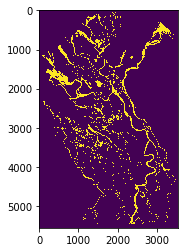

In [4]:
plt.imshow(water_mask, interpolation='none')

# Generate Orinoco Products

## Obtaining the Distance Function

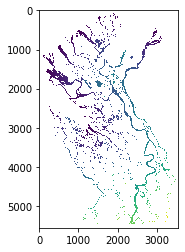

In [5]:
transform = profile['transform']
dx, dy = transform.a, -transform.e
dist = get_distance_along_channel_using_fmm(water_mask,
                                            ocean_mask,
                                            dx=dx,
                                            dy=dy,
                                            # removes areas with less than percentage of total size
                                            area_threshold=0.025,
                                            # Applys a 1 pixel buffer for distance computation
                                            # for artifical 8-connectivity.
                                            # See: https://github.com/scikit-fmm/scikit-fmm/issues/32
                                            # Removes buffer after computation complete.
                                            apply_pixel_buffer_for_distance_comp=True
                                            )
plt.imshow(dist, interpolation='none')

Save the distance product.

In [6]:
p = profile.copy()
p['dtype'] = 'float32'
with rasterio.open(tile_dir/f'distance_{tile_name}.tif', 'w', **p) as ds:
    ds.write(dist.astype(np.float32), 1)

## Segmentation of the Channel

In [33]:
pixel_step = 5
segments, interface_adj_segments = get_distance_segments(dist,
                                                         pixel_step,
                                                         dx=dx,
                                                         dy=dy,
                                                         connectivity=8,
                                                         min_size=4)

rag neighbors: 100%|██████████| 1020/1020 [00:00<00:00, 21543.91it/s]


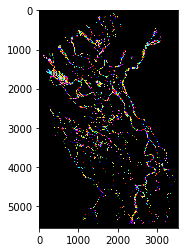

In [34]:
segments_rgb = label2rgb(segments, bg_label=0)
plt.imshow(segments_rgb, interpolation='none')

We save both the `segments` and the `segments_rgb` to disk.

In [35]:
p = profile.copy()
p['dtype'] = 'int32'
with rasterio.open(tile_dir/f'segments_{tile_name}.tif', 'w', **p) as ds:
    ds.write(segments.astype(np.int32), 1)

p = profile.copy()
p['dtype'] = 'float32'
p['count'] = 3
with rasterio.open(tile_dir/f'segments_rgb_{tile_name}.tif', 'w', **p) as ds:
    ds.write(segments_rgb.transpose([2, 0, 1]).astype(np.float32))

## Obtaining the Undirected Network

In [36]:
d = nx.get_node_attributes(chanG_undirected, 'label')
[n for n, l in d.items() if l in [13465, 13483]]

[(479655.0, 7617885.0)]

In [37]:
get_RAG_neighbors(segments, [13473])

rag neighbors: 100%|██████████| 1/1 [00:00<00:00, 1695.35it/s]


{13473: array([13431, 13513])}

In [38]:
list(nx.all_neighbors(chanG_undirected, (479625.0, 7617945.0)))

[(479595.0, 7618005.0), (479625.0, 7617945.0), (479655.0, 7617885.0)]

In [39]:
chanG_undirected = get_undirected_channel_network(segments, 
                                                  dist, 
                                                  profile, 
                                                  interface_adj_segments,
                                                  connectivity=8)

adding edges: 100%|██████████| 24586/24586 [00:00<00:00, 174905.84it/s]


## Obtaining the Directed Network

In [40]:
chanG = direct_channel_network_using_distance(chanG_undirected, 
                                              # The keywords below are how the pruning occurs
                                              # Specifies pruning will be done
                                              remove_danlging_segments=True, 
                                              # Do not prune nodes within 1 km of interface
                                              meters_to_interface_filter_buffer=1_000,     
                                              # Remove edge groups with an degree 1 endpoint and size <=3
                                              segment_threshold=3,
                                              # How many times to do this pruning
                                              dangling_iterations=1
                                              )

Let's do a quick sanity check.

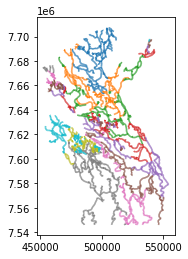

In [41]:
df_edges = export_edges_to_geodataframe(chanG, profile['crs'])
df_edges.plot(column='segment_id', categorical=True)

## Obtaining the Widths

### Using the distance transform

We are going to use the distance transform within a segment. We have a function that determines the width according to $2\cdot d - 1$ where d is the distance to the land mask according to the distance transform in a small 1-pixel buffer around the segment (if this is 0, we use the full distance transform on the channel mask).

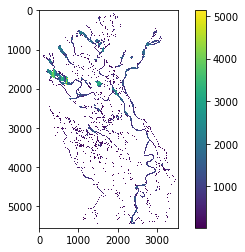

In [42]:
width_features = get_width_features_from_segments(segments, profile)
widths = get_array_from_features(segments, width_features)
plt.imshow(widths, interpolation='none')
plt.colorbar()

We now add these attributes to the graph.

In [43]:
chanG = add_width_features_to_graph(chanG, width_features.ravel())
node_data =dict(chanG.nodes(data=True))
random.choice(list(node_data.items()))

((454422.0, 7624395.0),
 {'label': 10959,
  'meters_to_interface': 22051.824994055172,
  'x': 454422.0,
  'y': 7624395.0,
  'interface_adj': False,
  'graph_degree': 2,
  'width_from_segment': 54.852813742385706})

### Using $\nabla \varphi$

We compute width using the gradient of the distance function (and possibly the network structure). First we obtain the orientation of along wich to obtain these measured widths (perpendicular to the artificial flow).

In [44]:
chanG = add_flow_attributes(chanG, dist, profile['transform'])

flow vector computation using network: 100%|██████████| 23439/23439 [00:03<00:00, 7358.56it/s]


In [45]:
seg_test = np.zeros(segments.shape)
seg_test[segments == 13473] =1
seg_test = nd.binary_dilation(seg_test, iterations=5)
p = profile.copy()
p['dtype'] = 'int32'
with rasterio.open(tile_dir/f'seg_test.tif', 'w', **p) as ds:
    ds.write(seg_test.astype(np.int32), 1)

To perform intersection, we must extract the polygons of the segments. This takes a bit of time to polygonize the segments, so be patient.

In [46]:
%%time

df_segments = get_segment_df(segments, chanG, profile)
df_segments.head()

CPU times: user 23.3 s, sys: 209 ms, total: 23.5 s
Wall time: 23.5 s


,label,geometry,perimeter,node,flow_vector_perp
0,1,"POLYGON ((506385.000 7707765.000, 506385.000 7...",1800.0,"(506205.0, 7707614.368421053)","(0.89259404, 0.4508613)"
1,2,"POLYGON ((505755.000 7707705.000, 505755.000 7...",120.0,None,None
2,3,"POLYGON ((506415.000 7707615.000, 506415.000 7...",1800.0,"(506262.2727272727, 7707471.363636363)","(0.90515584, 0.42507988)"
3,4,"POLYGON ((506535.000 7707495.000, 506535.000 7...",1920.0,"(506308.08510638296, 7707324.893617021)","(0.9201897, 0.39147285)"
4,5,"POLYGON ((506565.000 7707345.000, 506565.000 7...",1980.0,"(506372.1, 7707187.2)","(0.9279982, 0.37258467)"


We will save the geometries to a file for later inspection.

In [47]:
df_segments_out = change_tuples_to_vector(df_segments)
df_segments_out.to_file(tile_dir/'segments.geojson', 
                        driver='GeoJSON')

Now we extract the widths are associated geometry. This is the most expensive computation in the notebook, so be very patient. Could take 5 minutes or so.

In [48]:
%%time

df_geo_widths = get_geo_width_df(df_segments, chanG, radius=1)
df_geo_widths.head()

CPU times: user 3min 2s, sys: 314 ms, total: 3min 3s
Wall time: 3min 3s


,label,node,geometry,width_m
0,1,"(506205.0, 7707614.368421053)","LINESTRING (506475.000 7707750.749, 505965.000...",571.368401
2,3,"(506262.2727272727, 7707471.363636363)","LINESTRING (506535.000 7707599.442, 506025.000...",563.438911
3,4,"(506308.08510638296, 7707324.893617021)","LINESTRING (506565.000 7707434.192, 506055.000...",554.233590
4,5,"(506372.1, 7707187.2)","LINESTRING (506655.000 7707300.782, 506115.000...",581.897702
5,6,"(506428.15789473685, 7707051.578947368)","LINESTRING (506775.000 7707191.512, 506115.000...",711.690590


Let's save the widths again for later inspection.

In [49]:
df_geo_widths_out = change_tuples_to_vector(df_geo_widths)
df_geo_widths_out.to_file(tile_dir/'width_geometries.geojson', 
                          driver='GeoJSON')

We update the node attributes. And we see all of the attributes we have added.

In [50]:
chanG = update_graph_with_widths(chanG, df_geo_widths)

node_data =dict(chanG.nodes(data=True))
random.choice(list(node_data.items()))

((526714.5, 7593342.0),
 {'label': 18732,
  'meters_to_interface': 57367.22640569004,
  'x': 526714.5,
  'y': 7593342.0,
  'interface_adj': False,
  'graph_degree': 2,
  'width_from_segment': 104.16407864998739,
  'flow_vector_perp_grad': (-0.11792107, 0.9930229),
  'flow_vector_network': (0.9413032419808935, 0.337562152256824),
  'flow_vector_perp_network': (-0.337562152256824, 0.9413032419808935),
  'flow_vector_perp': (-0.11792107, 0.9930229),
  'width_m': 120.84314619314593})

# Save Network

We now save the nodes and edges to `geojson` files and serialize the NetworkX `DiGraph` with `pickle`.

In [51]:
df_nodes = export_nodes_to_geodataframe(chanG, profile['crs'])
df_nodes = change_tuples_to_vector(df_nodes)
df_edges = export_edges_to_geodataframe(chanG, profile['crs'])

In [52]:
df_edges.to_file(tile_dir/f'{tile_name}_edges.geojson', driver='GeoJSON')
df_nodes.to_file(tile_dir/f'{tile_name}_nodes.geojson', driver='GeoJSON')
nx.write_gpickle(chanG, tile_dir/f'{tile_name}_network.pkl')